[En français](../use-case_skewt_fr/)  

![ECCC logo](https://eccc-msc.github.io/open-data/img_eccc-logo.png)  

[TOC](https://eccc-msc.github.io/open-data/readme_en/) > [Usage overview](https://eccc-msc.github.io/open-data/usage/readme_en/) > WMS request in Python

# Use case: sounding graphs based on open-data

## Introduction

Weather, climate and water data from [MSC GeoMet](https://eccc-msc.github.io/open-data/msc-geomet/readme_en/) geospatial web services can be easily used to predict demand associated with certain products or services. This usage example shows how to extract and process raw sounding data with [Python](https://www.python.org/) programming language to create a tool to plot and display different data depending on the inputs provided. The interactive version is a lot more complete and user-friendly (link below), but the code is very complex and as such this simpler example was made as a teaching tool. This use case teaches you how to:
* Access and query sounding data from MSC GeoMet geospatial web services;
* Query layers to get data for specific locations;
* Create temporal queries;
* Show results in different formats including plots and data tables.

The [simple version of this Jupyter Notebook is available here](https://mybinder.org/v2/gh/PhilippeTh/open-data/Gerald_SkewT_Use_case_PT?labpath=%2Fdocs%2Fusage%2Fuse-case_skewt%2Fuse-case_skewt_en.ipynb).

[![badge](https://img.shields.io/badge/Simple%20version-binder-579ACA.svg?logo=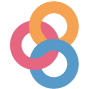)](https://mybinder.org/v2/gh/PhilippeTh/open-data/Gerald_SkewT_Use_case_PT?labpath=%2Fdocs%2Fusage%2Fuse-case_skewt%2Fuse-case_skewt_en.ipynb)

The [interactive version (this version) of this Jupyter Notebook is available here](https://mybinder.org/v2/gh/PhilippeTh/open-data/Gerald_SkewT_Use_case_PT?labpath=%2Fdocs%2Fusage%2Fuse-case_skewt%2Fuse-case_skewt-interactive_en.ipynb).

[![badge](https://img.shields.io/badge/Interactive%20version-binder-F5A252.svg?logo=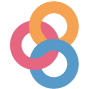)](https://mybinder.org/v2/gh/PhilippeTh/open-data/Gerald_SkewT_Use_case_PT?labpath=%2Fdocs%2Fusage%2Fuse-case_skewt%2Fuse-case_skewt-interactive_en.ipynb)

## Creation of a tool to extract and plot sounding data

Consider the following situation: Gerald, an aircraft pilot, would like to be able to access upper air observations from the Canadian data in an easily understandable and accurate manner, considering he can be needing it at any time of the day and would like to know forecasts for an upcoming flight. A friend of his also told him there might be uneven weather on the path he's chosen, as such Gerald would like to fact-check that information for himself and see whether he needs to maybe change his course or even delay or cancel his flight. Gerald wants to be able to get the information he needs in a timely manner using the soundings forecast obtained from MSC GeoMet geospatial web services.

To be able to see the data for a specific time and place, the first step is to query the ``Extract Sounding Data Geomet OGC API Process`` from MSC GeoMet to get the data associated with the provided model, model run, forecast hour and lat/lon through Python programming. To carry out this step, the Python modules must first be imported and values must be given to the request parameters. The layer used for this exemple will be the layer from the [Global Deterministic Prediction System (GDPS)](https://eccc-msc.github.io/open-data/msc-data/nwp_gdps/readme_gdps_en/) that contains the deterministic forecasts of elements of the atmosphere from the present day to 10 days in the future (``GDPS.ETA_TT``).

In [ ]:
# Remove the magic command to use out of Jupyter Notebook
%matplotlib widget

# Importation of Python modules
import base64
from datetime import datetime
import io
import logging
import math
import re
import requests

# The following modules must first be installed to use 
# this code out of Jupyter Notebook
from adjustText import adjust_text
from ipyleaflet import Map
from ipywidgets import BoundedFloatText, Button, Checkbox, Dropdown, HBox, HTML, Label, Output, Text, VBox

from matplotlib.font_manager import FontProperties
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as mpatheffects
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import metpy.calc as mpcalc
import metpy.interpolate as mpinterpolate

# Metpy throws a Cartopy warning for no reason if you don't put that even though Cartopy isn't used...
metpy_plot_logger = logging.getLogger('metpy.plots')
metpy_plot_logger.setLevel(logging.ERROR)

from metpy.plots import Hodograph, SkewT
from metpy.units import units

from owslib.wms import WebMapService
from pandas import date_range
import PIL

# Time format used is UTC±00:00
ISO_FORMAT = '%Y-%m-%dT%H:%M:%SZ'

Once the imports are done, we create a class to encapsulate the graphs' creation function so they can be called whenever we want and with different arguments.

In [ ]:
class SoundingProcessRequest():
    """
    Class used to make the OAProc request.
    """

    def __init__(self, fh, lat, lon, model, mr, convection_indices=True, temperature_data=True, wind_data=True, noval=True, url=None) -> None:
        """
        :param fh: string -> Forecast hour that starts with 3 numbers (i.e. 003).
        :param lat: float -> Latitude (i.e. -12.3456).
        :param lon: float -> Longitude (i.e. 123.4567).
        :param model: string -> RDPS, GDPS or HRDPS.
        :param mr: string -> Model run in ISO format (i.e. 2022-01-31T12:00:00Z).
        :param convection_indices: bool -> True (default) means you wish to have the convection indices;
                                           False means you will not be needing them.
        :param temperature_data: bool -> True (default) means you wish to have temperature and dewpoint sounding data;
                                         False means you will not be needing them.
        :param wind_data: bool -> True (default) means you wish to have the wind data;
                                  False means you will not be needing them.
        :param noval: bool -> True (default) means you don't need pressure levels above 100mbar;
                              False means you want all pressure levels (may fail when making sounding graphs or make them unreadable).
        :param url: string -> Fully qualified URL to the extract-sounding-data OGC API Process.
        """
        self.forecast_hour = fh
        self.lat = lat
        self.lon = lon
        self.model = model
        self.model_run = mr
        self.convection_indices = convection_indices
        self.temperature_data = temperature_data
        self.wind_data = wind_data
        self.novalues_above_100mbar = noval
        self.url = url or 'https://api.weather.gc.ca/processes/extract-sounding-data/execution'
        self.data = self.__create_request()

    def __create_request(self):
        """
        Make the request the the extract-sounding-data OAProc using the given information.
        """
        headers = {
            'Accept': 'application/json',
            'Content-Type': 'application/json',
        }
        body = {
            'inputs': {
                'forecast_hour': self.forecast_hour[0:3],
                'lat': self.lat,
                'lon': self.lon,
                'model': self.model,
                'model_run': self.model_run,
                'convection_indices': self.convection_indices,
                'temperature_data': self.temperature_data,
                'wind_data': self.wind_data,
                'novalues_above_100mbar': self.novalues_above_100mbar,
            }
        }
        resp = requests.post(self.url, json=body, headers=headers)
        return resp.json()


class SoundingGraphs(SoundingProcessRequest):
    """
    Class for making the SkewT, Hodograph and Convection Indices table.
    """

    def __init__(self, fh, lat, lon, model, mr, convection_indices=True, temperature_data=True, wind_data=True, noval=True, url=None) -> None:
        """
        :param fh: string -> :param fh: string -> Forecast hour that starts with 3 numbers (i.e. 003).
        :param lat: float -> Latitude (i.e. -12.3456).
        :param lon: float -> Longitude (i.e. 123.4567).
        :param model: string -> RDPS, GDPS or HRDPS.
        :param mr: string -> Model run in ISO format (i.e. 2022-01-31T12:00:00Z).
        :param convection_indices: bool -> True (default) means you wish to have the convection indices;
                                           False means you will not be needing them.
        :param temperature_data: bool -> True (default) means you wish to have temperature and dewpoint sounding data;
                                         False means you will not be needing them.
        :param wind_data: bool -> True (default) means you wish to have the wind data;
                                  False means you will not be needing them.
        :param noval: bool -> True (default) means you don't need pressure levels above 100mbar;
                              False means you want all pressure levels (may fail when making sounding graphs or make them unreadable).
        :param url: string -> Fully qualified URL to the extract-sounding-data OGC API Process.
        """
        super().__init__(fh, lat, lon, model, mr, convection_indices, temperature_data, wind_data, noval, url)
        plt.ioff()
        plt.close('all')
        self.p = []  # List to store pressure levels
        self.t = []  # List to store temperatures
        self.td = []  # List to store dew point temperatures
        self.ws = []  # List to store wind speeds
        self.wd = []  # List to store wind directions
        self.deg_symbol = u'\N{DEGREE SIGN}'
        self.__sort_data()

    def __sort_data(self):
        """
        Store sounding data from the json returned by the Process.
        """
        # Store all sounding data
        if self.temperature_data and self.wind_data:
            for key, val in self.data['properties'].items():
                if re.search(r'(\d+)mbar', key):
                    self.p.append(val['pressure'])
                    self.t.append(val['air_temperature'])
                    self.td.append(val['dew_point_temperature'])
                    self.ws.append(val['wind_speed'])
                    self.wd.append(val['wind_direction'])
            self.p *= units.hPa
            self.t *= units.degC
            self.td *= units.degC
            self.ws *= units.knots
            self.wd *= units.degrees
            self.u, self.v = mpcalc.wind_components(self.ws, self.wd)
        # The case where you have temperature and dewpoint but no wind informations doesn't
        # let you build a SkewT nor a Hodograph, but it's still here in case.
        elif self.temperature_data:
            for key, val in self.data['properties'].items():
                if re.search(r'(\d+)mbar', key):
                    self.p.append(val['pressure'])
                    self.t.append(val['air_temperature'])
                    self.td.append(val['dew_point_temperature'])
            self.p *= units.hPa
            self.t *= units.degC
            self.td *= units.degC
        elif self.wind_data:
            for key, val in self.data['properties'].items():
                if re.search(r'(\d+)mbar', key):
                    self.p.append(val['pressure'])
                    self.ws.append(val['wind_speed'])
                    self.wd.append(val['wind_direction'])
            self.p *= units.hPa
            self.ws *= units.knots
            self.wd *= units.degrees
            self.u, self.v = mpcalc.wind_components(self.ws, self.wd)

        # Store convection indices so they can then be placed inside a table
        if self.convection_indices:
            cape = list(self.data['properties']['CAPE'].values())
            cin = list(self.data['properties']['CIN'].values())
            lcl = list(self.data['properties']['LCL'].values())
            li = list(self.data['properties']['LI'].values())
            lfc = list(self.data['properties']['LFC'].values())
            el = list(self.data['properties']['EL'].values())

            # Rearrange the values to get first value of every list in the same row
            self.conv_indices = conv_indices = [list(row) for row in zip(cape, cin, lcl, li, lfc, el)]
            for i, row in enumerate(conv_indices):
                for j, elem in enumerate(row):
                    # Round the values
                    if isinstance(elem, float):
                        conv_indices[i][j] = round(conv_indices[i][j])

            # Add units on the last row of the table
            if self.data['properties']['LI_unit'] == "--":
                self.data['properties']['LI_unit'] = "K"
            conv_indices.append(
                [self.data['properties']['CAPE_unit'],
                 self.data['properties']['CIN_unit'],
                 self.data['properties']['LCL_unit'],
                 self.data['properties']['LI_unit'],
                 self.data['properties']['LFC_unit'],
                 self.data['properties']['EL_unit']]
            )

    def create_skewt(self, hodograph=False, convection_table=False):
        """
        Function used to make a SkewT graph.
        :param hodograph: bool -> True means a hodograph will also be added.
        :param convection_table: bool -> True means a convection indices table will also be added.
        """
        # Need to adjust figure size depending on how many things are in it
        if hodograph and convection_table:
            self.fig = plt.figure(figsize=(16, 18), tight_layout=True)
            gs = gridspec.GridSpec(3, 1, height_ratios=(8, 8, 1))
            skew = SkewT(self.fig, rotation=45, subplot=gs[0])
        elif hodograph:
            self.fig = plt.figure(figsize=(14, 14), tight_layout=True)
            gs = gridspec.GridSpec(2, 1)
            skew = SkewT(self.fig, rotation=45, subplot=gs[0])
        elif convection_table:
            self.fig = plt.figure(figsize=(14, 9), tight_layout=True)
            gs = gridspec.GridSpec(2, 1, height_ratios=(8, 1))
            skew = SkewT(self.fig, rotation=45, subplot=gs[0])
        else:
            self.fig = plt.figure(figsize=(10, 8))
            skew = SkewT(self.fig, rotation=45)

        # Plot the data using normal plotting functions, in this case using
        # log scaling in Y, as dictated by the typical meteorological plot.
        skew.plot(self.p[:len(self.t)], self.t, 'r', label='Temperature')
        skew.plot(self.p[:len(self.td)], self.td, 'g', label='Dewpoint')
        skew.plot_barbs(self.p[:len(self.ws)], self.u, self.v)
        skew.ax.set_ylim(1050, 100)
        skew.ax.set_xlim(-40, 60)
        skew.ax.xaxis.set_label_text('Temperature (°C)')
        skew.ax.yaxis.set_label_text('Pressure (hPa|mbar)')

        # Add a secondary axis that automatically converts between pressure and height
        # assuming a standard atmosphere. The value of -0.12 puts the secondary axis
        # 0.12 normalized (0 to 1) coordinates left of the original axis.
        secax = skew.ax.secondary_yaxis(
            -0.12,
            functions=(
                lambda p: mpcalc.pressure_to_height_std(units.Quantity(p, 'hPa')).m_as('km'),
                lambda h: mpcalc.height_to_pressure_std(units.Quantity(h, 'km')).m
            )
        )
        secax.yaxis.set_major_locator(plt.FixedLocator([0, 1, 3, 6, 9, 12, 15]))
        secax.yaxis.set_minor_locator(plt.NullLocator())
        secax.yaxis.set_major_formatter(plt.ScalarFormatter())
        secax.set_ylabel('Height (km)')

        # Calculate full parcel profile and add to plot as black line
        prof = mpcalc.parcel_profile(self.p, self.t[0], self.td[0]).to('degC')
        skew.plot(self.p, prof, 'k', linewidth=2, label='Parcel profile*')

        # Shade areas of CAPE and CIN
        skew.shade_cin(self.p, self.t, prof, self.td, label='CIN*')
        skew.shade_cape(self.p, self.t, prof, label='CAPE*')

        # Slanted line at 0 isotherm
        skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

        # Add the relevant special lines
        wet_bulb = mpcalc.wet_bulb_temperature(self.p, self.t, self.td)
        skew.plot(self.p, wet_bulb, 'b', linewidth=1, label='Wet Bulb*')
        skew.plot_dry_adiabats()
        skew.plot_moist_adiabats()
        skew.plot_mixing_lines()

        # Add title with all the data that was used for the plot
        skew.ax.title.set_text(f'{self.model} Sounding at (' +
                                f'{str(self.lat) + self.deg_symbol + "N" if self.lat >= 0 else str(self.lat*-1) + self.deg_symbol + "S"}, ' +
                                f'{str(self.lon) + self.deg_symbol + "E" if self.lon >= 0 else str(self.lon*-1) + self.deg_symbol + "W"}) ' + '\n' +
                                f'Model Run: {self.model_run} ' + '\n' +
                                f'Forecast Hour: {self.forecast_hour[0:5]}{datetime.strptime(self.forecast_hour[5:], "%Y-%m-%d %H:%M:%S").strftime(ISO_FORMAT)}'
                               )
        skew.ax.legend()

        if hodograph:
            self.create_hodograph(gs=gs)

        if convection_table:
            self.create_conv_table(gs)

    def create_hodograph(self, gs=None, convection_table=False):
        """
        Function used to make a Hodograph.
        :param gs: gridspec.GridSpec -> Needed when called from create_skewt so that the Hodograph appears
                                        under the SkewT graph and the convection indices table under the Hodograph.
        :param convection_table: bool -> True means a convection indices table will also be added.
                                         False when called from create_skewt since that function will create the table.
        """
        if gs:
            skewt = True
            ax = self.fig.add_subplot(gs[1])
        elif convection_table:
            skewt = False
            self.fig = plt.figure(figsize=(14, 9), tight_layout=True)
            gs = gridspec.GridSpec(2, 1, height_ratios=(8, 1))
            ax = self.fig.add_subplot(gs[0])
        else:
            skewt = False
            self.fig = plt.figure(figsize=(10, 8))
            ax = self.fig.add_subplot(1, 1, 1)

        # Default pressure level values to display on the Hodograph.
        # You may add more or remove some as you please.
        boundaries_default = [950, 850, 700, 500, 300, 250]

        # Always show first pressure level
        boundaries_p = [self.p[0].magnitude]

        # Also show all the ones from the list above, but only if they're over
        # the first pressure level and are at least 50mbar over first pressure level
        # i.e. if first pressure level is at 855mbar, don't show 950 nor 850
        boundaries_p.extend([bd for bd in boundaries_default if ((boundaries_p[0]-bd)>=50 and bd>=self.p[-1].magnitude)])
        boundaries_p *= units.hPa
        u_pts, v_pts = mpinterpolate.interpolate_1d(boundaries_p, self.p, self.u, self.v)
        boundaries_p[0] = round(boundaries_p[0])

        # Add the points on the Hodograph for the chosen pressure levels
        ax.scatter(u_pts, v_pts, c="black", zorder=10)
        texts = []
        for up, vp, z in zip(u_pts, v_pts, boundaries_p):
            z_str = int(z.magnitude)
            texts.append(ax.text(up, vp, z_str, ha='center', fontsize=10,
                         path_effects=[mpatheffects.withStroke(foreground='white', linewidth=2)],
                         zorder=12)
                        )

        # Scale hodograph according to strongest wind value
        max_range = math.ceil(max(self.ws).magnitude) + 1
        h = Hodograph(ax, component_range=max_range)

        if max_range < 50:
            inc = math.ceil(max_range / 10)
        else:
            inc = 5 * math.ceil(max_range / 100)

        # Put axes in the middle of the graph
        ax.spines['left'].set_position('zero')
        ax.spines['bottom'].set_position('zero')
        ax.patch.set_edgecolor('black')
        ax.patch.set_linewidth(0.5)

        # Add color that changes with pressure levels
        h.plot_colormapped(self.u, self.v, self.p)

        # Rescale hodograph to zoom where the values are
        # Comment h.ax.autoscale() if you want the entire Hodograph instead
        h.ax.autoscale()
        bottom, top = h.ax.get_ylim()
        left, right = h.ax.get_xlim()

        # Add the grid lines for the wind speeds
        h.add_grid(increment=inc)

        # Make sure axes stay inside the plot if the winds are all super far in one direction
        if left > 0:
            left = -1
        if bottom > 0:
            bottom = -1
        if right < 0:
            right = 1
        if top < 0:
            top = 1

        # Resize the hodograph to zoom in on the plot, but only show values on the longest axis
        # and add a little buffer to make sure the entire plot always fits inside.
        norm_bottom = abs(bottom)
        norm_left = abs(left)
        whole, remainder = divmod(max_range, inc)
        highest = max(norm_bottom, top, norm_left, right)
        if highest in (norm_bottom, top):
            if highest == norm_bottom:
                norm_bottom = (whole + math.ceil(remainder/inc)) * inc
            else:
                top = (whole + math.ceil(remainder/inc)) * inc
            ax.set_ylim(bottom=-norm_bottom, top=top)
            ax.set_xlim(left=-norm_left, right=right)

            ax.yaxis.set_major_locator(mticker.MultipleLocator(inc))
            ticks_loc_y = ax.get_yticks().tolist()
            ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc_y))
            ax.set_yticklabels([f'{abs(int(y))}' for y in ticks_loc_y])
            ax.set_xticks([])
        else:
            if highest == norm_left:
                norm_left = (whole + math.ceil(remainder/inc)) * inc
            else:
                right = (whole + math.ceil(remainder/inc)) * inc
            ax.set_ylim(bottom=-norm_bottom, top=top)
            ax.set_xlim(left=-norm_left, right=right)

            ax.xaxis.set_major_locator(mticker.MultipleLocator(inc))
            ticks_loc_x = ax.get_xticks().tolist()
            ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc_x))
            ax.set_xticklabels([f'{abs(int(x))}' for x in ticks_loc_x])
            ax.set_yticks([])

        # Remove axes labels since the axes are in the middle of the plot
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Add full title if there is no SkewT plot
        if skewt:
            h.ax.title.set_text('Hodograph, Wind Speed in knots, Height in hPa')
        else:
            h.ax.title.set_text(f'{self.model} Sounding at (' +
                                f'{str(self.lat) + self.deg_symbol + "N" if self.lat >= 0 else str(self.lat*-1) + self.deg_symbol + "S"}, ' +
                                f'{str(self.lon) + self.deg_symbol + "E" if self.lon >= 0 else str(self.lon*-1) + self.deg_symbol + "W"}) ' + '\n' +
                                f'Model Run: {self.model_run} ' + '\n' +
                                f'Forecast Hour: {self.forecast_hour[0:5]}{datetime.strptime(self.forecast_hour[5:], "%Y-%m-%d %H:%M:%S").strftime(ISO_FORMAT)}' + '\n' +
                                'Hodograph, Wind Speed in knots, Height in hPa'
                               )
        # Make sure hodograph points' text don't overlap
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='r', lw=0.5), expand_text=(5, 5))

        if convection_table:
            self.create_conv_table(gs)

    def create_conv_table(self, gs=None):
        """
        Function used to make a Convection Indices table.
        :param gs: gridspec.GridSpec -> Needed when called from create_skewt or create_hodograph
                                        so that the table appears under the graphs.
        """
        if gs:
            table_ax = self.fig.add_subplot(gs[-1])
        else:
            self.fig = plt.figure(figsize=(14, 4), tight_layout=True)
            table_ax = self.fig.add_subplot(1, 1, 1)
        table_ax.axis('tight')
        table_ax.axis('off')

        # Table's column and row names
        col_names = ['CAPE', 'CIN', 'LCL', 'LI', 'LFC', 'EL']
        row_names = ['SFC', 'ML', 'MU', 'Units']
        tab = table_ax.table(cellText=self.conv_indices, colLabels=col_names, rowLabels=row_names, loc='center', cellLoc='center')

        # Change table font size and scale to look better
        tab.auto_set_font_size(False)
        tab.set_fontsize(12)
        tab.scale(1.5, 1.5)

        # Populate the table
        for (row, col), cell in tab.get_celld().items():
            # Put row and column titles bold
            if (row == 0) or (col == -1):
                cell.set_text_props(fontproperties=FontProperties(size=12, weight='bold'))

        # Add full title if there's nothing but the table
        if not gs:
            table_ax.title.set_text(f'{self.model} Sounding at (' +
                                    f'{str(self.lat) + self.deg_symbol + "N" if self.lat >= 0 else str(self.lat*-1) + self.deg_symbol + "S"}, ' +
                                    f'{str(self.lon) + self.deg_symbol + "E" if self.lon >= 0 else str(self.lon*-1) + self.deg_symbol + "W"}) ' + '\n' +
                                    f'Model Run: {self.model_run} ' + '\n' +
                                    f'Forecast Hour: {self.forecast_hour[0:5]}{datetime.strptime(self.forecast_hour[5:], "%Y-%m-%d %H:%M:%S").strftime(ISO_FORMAT)}'
                                   )
        

Next we create some useful functions that'll help us with populating forecast hours and model runs and repopulate when there's a model change or, in the case of forecast hours, when there's a model run change as well. That is possible with the help of a ``GetCapabilities`` request from within the ``wms_request`` function, which will return the first and last times available as well as the interval between them and the default value. Note that older values may become unavailable as time passes, changing the model will always refresh the available model runs and forecast hours.

The ``run_hours`` function will then create a list from the values that we got from the ``GetCapabilities`` and the ``time_parameters`` function will format them properly and return the list created, the default value and the interval.

In [ ]:
def time_parameters(wms, layer, time_field):
    """
    Returns list of datetimes, the default time value and the interval beetween each value.

    :param wms: owslib.map.wms130.WebMapService_1_3_0 object -> GetCapabilities on specified layer.
    :param layer: string -> Layer being queried.
    :param time_field: string -> Name of the the field to look for in the GetCapabilities.
    """
    start_time, end_time, interval = (wms[layer]
                                      .dimensions[time_field]['values'][0]
                                      .split('/')
                                      )
    default = wms[layer].dimensions[time_field]['default']
    default = datetime.strptime(default, ISO_FORMAT)
    start_time = datetime.strptime(start_time, ISO_FORMAT)
    end_time = datetime.strptime(end_time, ISO_FORMAT)
    interval = re.sub(r'\D[a-zA-Z]', '', interval)
    return run_hours(start_time, end_time, interval), default, int(re.sub(r'\D', '', interval))

def run_hours(start_time, end_time, interval):
    """
    Create a list of datetimes from start_time, end_time and interval.

    :param start_time: datetime object
    :param end_time: datetime object
    :param interval: int -> Number of hours that separates each timestep in the list.
    """
    return date_range(start=start_time,end=end_time, freq=interval).to_pydatetime().tolist()

def wms_request(layer):
    """
    GetCapabilities on specified layer.

    :param layer: string -> Layer being queried.
    """
    return WebMapService('https://geo.weather.gc.ca/geomet?SERVICE=WMS' +
                         '&REQUEST=GetCapabilities' + f'&LAYERS={layer}',
                         version='1.3.0',
                         timeout=300)

``create_dropdown`` helper function instead of creating 3 Dropdowns.
Using ``GDPS`` as the default, make the ``GetCapabilities`` requests and populate the forecast hours and model runs Dropdowns.

In [ ]:
def create_dropdown(options, default_value, desc):
    """
    Function to create dropdowns rather than creating them one by one.

    :param options: list -> All choices that will appear in the dropdown.
    :param default_value: String -> A value that is inside "options" that will appear as the default.
    :param desc: String -> Name of the dropdown.
    """
    return Dropdown(
        options=options,
        value=default_value,
        description=desc,
        disabled=False,
    )

# Small dictionnary to associate a Model with its Layer name for the GetCapabilities
LAYERS = {
    'GDPS': 'GDPS.ETA_TT',
    'RDPS': 'RDPS.ETA_TT',
    'HRDPS': 'HRDPS.CONTINENTAL_TT',
}

# Create dropdown for Model selection
model = create_dropdown(list(LAYERS.keys()), 'GDPS', 'Model')

# Make the GetCapabilities on the select layer, in this case GDPS (default)
wms = wms_request(LAYERS[model.value])

# Get options and default value to populate Model Run dropdown
mr, mr_default, _ = time_parameters(wms, LAYERS[model.value], 'reference_time')
model_run = create_dropdown(mr, mr_default, 'Model run')

# Get options and default value to populate Forecast Hour dropdown
fhs, fh_default, interval = time_parameters(wms, LAYERS[model.value], 'time')
forecast_hour = create_dropdown([f'{interval*i:03}: {fh}' for i, fh in enumerate(fhs)],
                                 f'{int((fh_default - fhs[0]).total_seconds() / 3600):03}: {fh_default}',
                                 'Forecast hour')

# Have Model Run and Forecast Hour dropdowns appear side by side
time_select = HBox([model_run, forecast_hour])

Create 3 Checkboxes, they'll be used to select which of ``Skew-T Log-P diagram``, ``Hodograph``, ``Convection Indices Table`` or any combination of them will be generated.

In [ ]:
# Add 3 checkboxes to select which graphs/table you wish to see
skewt_cb = Checkbox(
    value=True,
    description='Skew-T',
    disabled=False,
    indent=False
)
hodo_cb = Checkbox(
    value=True,
    description='Hodograph',
    disabled=False,
    indent=False
)
conv_cb = Checkbox(
    value=True,
    description='Convection Indices',
    disabled=False,
    indent=False
)

# Stack the checkboxes on top of one another and put them beside the Model selection
checkboxes = VBox([skewt_cb, hodo_cb, conv_cb])
model_select = HBox([model, checkboxes])

Create latitude and longitude ``BoundedFloatText`` widgets. These fields may only contain numbers and decimals and you may either type the lats/lons by hand, enter a station ID in the station ID field or click on the map (station ID and map appear later in the code).

Create a ``generate_button`` that will be used to call the plotting functions using all the fields' information.

In [ ]:
# Starting position for the map (roughly the center of Canada)
center = [56.1303, -106.3468]

# Latitude and Longitude selected by the user
latitude = BoundedFloatText(
    value=center[0],
    min=-90.0,
    max=90.0,
    step=0.0001,
    description='Lat:',
    disabled=False,
    color='black'
)
longitude = BoundedFloatText(
    value=center[1],
    min=-180.0,
    max=180.0,
    step=0.0001,
    description='Lon:',
    disabled=False,
    color='black'
)

# Button to start graphs/table generation
generate_button = Button(
    description='Generate',
    disabled=False,
    button_style='',
    tooltip="Click to generate what you've selected",
    icon='line-chart'
)

# Put Latitude and Longitude side by side
latlon = HBox([latitude, longitude])

Use the url below to fetch all possible station IDs, names and lats/lons and store them inside a ``dictionnary``. Create a Text box where the station ID may be entered and, using the ``on_submit`` event handler, populate latitude and longitude fields with the station ID's lat/lon. Also create another Text box that will simply show the name of the selected station ID to validate you've entered the correct ID. Value will be ``Invalid Station`` if what has been entered inside the station ID field is not present inside the file.

In [ ]:
# Go fetch all station names from this text file
stations_file = 'https://dd.weather.gc.ca/vertical_profile/doc/station_list_for_vertical_profile.txt'
response = requests.get(stations_file)
stations = dict()
get_line = False
# Search line by line using Regex to find station, station ID and its lon/lat
for line in response.text.splitlines():
    if line != '' and get_line:
        stn = re.search(r"stn='(.*?)'", line).group(1)
        stn_id = re.search(r"stn_id='*(.*?)'", line).group(1)
        stn_lon = float(re.search(r"lon=([+-]?\d+\.\d+)", line).group(1))
        stn_lat = float(re.search(r"lat=([+-]?\d+\.\d+)", line).group(1))
        stations[stn_id] = {
            'Station': stn,
            'Lon': stn_lon,
            'Lat': stn_lat,
        }
    # Start looking for stations after you've passed this line in the text file
    if 'Forecast Sites' in line:
        get_line = True

# Text box to enter station ID
station_id = Text(
    value='',
    placeholder='ex.: CYVO',
    description='Station Id: ',
    disabled=False
)

# Uneditable text box to show the station's name once an ID has been entered (to validate you've entered the correct station ID).
# The station names in the text file do not follow any rules (sometimes underscores, hyphens, spaces, etc.).
# Because of that, this box is only there to show the selected station once an ID has been entered and cannot be used to find the station.
station_name = Text(
    value='',
    placeholder='Name appears here',
    description='Station: ',
    disabled=True
)

# Function that will be called when a station ID has been submitted
def on_station_entered(sender):
    if station_id.value in stations:
        station_name.value = stations[station_id.value]['Station']
        latitude.value = stations[station_id.value]['Lat']
        longitude.value = stations[station_id.value]['Lon']
    # If the station ID isn't in the list, put 'Invalid station' in the fields
    else:
        station_id.value = 'Invalid station'
        station_name.value = 'Invalid station'

# Event handler to watch for station ID submission
station_id.on_submit(on_station_entered)

# Put station ID and station name text boxes side by side
stations_hbox = HBox([station_id, station_name])

Create the Map widget. Will be used to display current lat/lon on Map hover and also to populate latitude and longitude fields on Map click.

In [ ]:
# Create a map that:
#     Is centered around the center of Canada.
#     Has a min zoom of 3 so that you can't see repeated maps side by side.
#     Uses world copy jump so that if you keep scrolling in one direction the
#     lats/lons won't keep increasing and will instead loop around.
m = Map(center=center,
        scroll_wheel_zoom=True,
        bounce_at_zoom_limits=False,
        double_click_zoom=False,
        min_zoom=3,
        zoom=4,
        world_copy_jump=True)

Using the ``on_interaction`` event handler, create events for Map hover (show current lat/lon) and Map click (populate latidude and longitude fields with the lat/lon of where you clicked). The ``if`` conditions are there to make sure the lat/lon returned from the click are within the world bounds, otherwise it loops around until it they are.

In [ ]:
def handle_map_interaction(**kwargs):
    # If map is clicked, populate lat/lon fields with the chosen lat/lon
    if kwargs.get('type') == 'click':
        lat, lon = kwargs.get('coordinates')
        if lat > 85.06:
            while lat > 85.06:
                lat -= 170.12
        elif lat < -85.06:
            while lat < -85.06:
                lat += 170.12
        if lon > 180.0:
            while lon > 180.0:
                lon -= 360.0
        elif lon < -180.0:
            while lon < -180.0:
                lon += 360.0
        latitude.value = round(lat, 4)
        longitude.value= round(lon, 4)
    # While map is hovered, display current lat/lon
    if kwargs.get('type') == 'mousemove':
        lat, lon = kwargs.get('coordinates')
        label.value = str((round(lat, 4), round(lon, 4)))

# Event handler to watch for map interactions
m.on_interaction(handle_map_interaction)

Using the ``observe`` event handler, change the values of possible model runs and forecast hours to match the newly selected model.

In [ ]:
def model_change_eventhandler(change):
    """
    When you switch between models, possible model runs and forecast hours need to change accordingly.

    :param change: traitlets.utils.bunch.Bunch object -> Gives you access to old and new value of Model dropdown as well as other properties.
    """
    wms = wms_request(LAYERS[change.new])
    new_mr, new_mr_default, _ = time_parameters(wms, LAYERS[change.new], 'reference_time')
    model_run.options = new_mr
    model_run.value = new_mr_default

    new_fh, new_fh_default, new_interval = time_parameters(wms, LAYERS[change.new], 'time')
    forecast_hour.options = [f'{new_interval*i:03}: {new_fh[i]}' for i in range(len(new_fh))]
    forecast_hour.value = f'{int((new_fh_default - new_fh[0]).total_seconds() / 3600):03}: {new_fh_default}'

    # Convection indices aren't available for HRDPS
    if change.new == 'HRDPS':
        conv_cb.disabled = True
        conv_cb.value = False
    else:
        conv_cb.disabled = False

# Call model_change_eventhandler when model dropdown's value is changed
model.observe(model_change_eventhandler, names='value')

Using the ``observe`` event handler, change the values of possible forecast hours to match the newly selected model run.

In [ ]:
def model_run_change_eventhandler(change):
    """
    When you switch between model runs, possible forecast hours need to change accordingly.

    :param change: traitlets.utils.bunch.Bunch object -> Gives you access to old and new value of Model Run dropdown as well as other properties.
    """
    delta = change.old - change.new
    new_fh = [f'{option[:5]}{datetime.strptime(option[5:], "%Y-%m-%d %H:%M:%S") - delta}' for option in forecast_hour.options]
    new_fh_default = f'{forecast_hour.value[:5]}{datetime.strptime(forecast_hour.value[5:], "%Y-%m-%d %H:%M:%S") - delta}'

    forecast_hour.options = new_fh
    forecast_hour.value = new_fh_default

# Call model_run_change_eventhandler when model_run dropdown's value is changed
model_run.observe(model_run_change_eventhandler, names='value')

Create an Output widget for the generated graphs and one for the Download button. Output widgets can be emptied and the contents can be replaced, which is very helpful to clear previous graphs and show the new one or to show the Download button only when there is a graph. The code below is used to make the calls to create the graphs, handle Generate, Previous and Next buttons and to determine when the Download button should be showed (and all interactions between those buttons).

In [ ]:
# Output widget to capture graphs and prints
out = Output()
# Output widget for Download button
out_download = Output()

class GenerateDownload:

    def __init__(self) -> None:
        # Dict to store current graphs' values
        self.current_selection = {}
        # Variable to store forecast hour options iterator
        self.fh_iter = None

    def widgets_disabled(self, is_disabled, index=None):
        """
        Disable widgets while graphs are being generated.

        :param is_disabled: bool -> True to disable widgets.
        :param index: int -> Index of current Forecast Hour from all Forecast Hour options.
                             If you're at the last forecast hour, never enable next_button.
                             If you're at the first forecast hour, never enable previous_button.
        """
        generate_button.disabled = is_disabled
        skewt_cb.disabled = is_disabled
        hodo_cb.disabled = is_disabled
        # Convection indices unavailable for HRDPS, so keep it disabled
        if model.value != 'HRDPS' or is_disabled:
            conv_cb.disabled = is_disabled
        model.disabled = is_disabled
        model_run.disabled = is_disabled
        forecast_hour.disabled = is_disabled
        latitude.disabled = is_disabled
        longitude.disabled = is_disabled
        station_id.disabled = is_disabled
        # Only enable if index is correct.
        if index is not None:
            if index != 1:
                previous_button.disabled = is_disabled
            if index != self.fh_iter.last_index:
                next_button.disabled = is_disabled
        # Still disable with other widgets when graphs are being generated.
        elif is_disabled:
            previous_button.disabled = is_disabled
            next_button.disabled = is_disabled

    def generate(self):
        """
        Clear current output and generate new graphs.
        """
        # Clear current output
        out_download.clear_output()
        # Wait until there's something new to add before clearing output.
        out.clear_output(wait=True)
        # Run the code unless user unselected everything
        if any([self.current_selection['skewt'], self.current_selection['hodo'], self.current_selection['conv_table']]):
            wind_data = False
            temperature_data = False
            convection_indices = False
            # Change variables according to checkbox selection
            if self.current_selection['skewt']:
                wind_data = True
                temperature_data = True
            if self.current_selection['hodo']:
                wind_data = True
            if self.current_selection['conv_table']:
                convection_indices = True
            try:
                # Create SoundingGraphs object with the given data
                sounding = SoundingGraphs(self.current_selection['fh'],
                                          self.current_selection['lat'],
                                          self.current_selection['lon'],
                                          self.current_selection['model'],
                                          self.current_selection['mr'].strftime(ISO_FORMAT),
                                          convection_indices,
                                          temperature_data,
                                          wind_data)
                # Call correct function depending on checkbox selection
                if self.current_selection['skewt']:
                    sounding.create_skewt(hodograph=self.current_selection['hodo'], convection_table=self.current_selection['conv_table'])
                elif self.current_selection['hodo']:
                    sounding.create_hodograph(convection_table=self.current_selection['conv_table'])
                else:
                    sounding.create_conv_table()
                img_buf = io.BytesIO()
                plt.savefig(img_buf, format='png')
                # Display figure and enable Download Button
                display(PIL.Image.open(img_buf))
                self.display_download_button(img_buf)
                img_buf.close()
                # Return True to let the calling function know the graphs were successfully created
                return True
            except KeyError as e:
                # KeyError happens when you ask for data that is unavailable or missing
                print('Sounding unavailable for:')
                print(f'Lat: {round(self.current_selection["lat"], 2)}')
                print(f'Lon: {round(self.current_selection["lon"], 2)}')
                print(f'Model: {self.current_selection["model"]}')
                print(f'Model run: {self.current_selection["mr"]}Z')
                print(f'Forecast hour: {self.current_selection["fh"]}Z')
                # Return False to let the calling function know the graphs were not created
                return False
        # Print this message if user unselected everything
        else:
            print("Usually it's more useful if you select something...")
            # Return False to let the calling function know the graphs were not created
            return False

    
    # This decorator makes it so everything that is displayed or printed will
    # get put inside "out", which is the Output widget we created earlier
    @out.capture()
    def on_generate_button_clicked(self, b):
        # First disable all widgets so the user can't changes values while graphs are being created
        self.widgets_disabled(True)
        # Store the current values so that even if the user changes everything after
        # graphs creation, the data can still be accessed for Download and Previous/Next buttons.
        self.current_selection['model'] = model.value
        self.current_selection['mr'] = model_run.value
        self.current_selection['fh'] = forecast_hour.value
        self.current_selection['fh_options'] = forecast_hour.options
        self.current_selection['lat'] = latitude.value
        self.current_selection['lon'] = longitude.value
        self.current_selection['skewt'] = skewt_cb.value
        self.current_selection['hodo'] = hodo_cb.value
        self.current_selection['conv_table'] = conv_cb.value

        # Index of the selected forecast hour with respect to all options
        # since Previous/Next buttons need to know that to work correctly
        fh_index = self.current_selection['fh_options'].index(self.current_selection['fh']) + 1

        # "Previous" doesn't exist in Python, needs a custom implementation
        self.fh_iter = TwoWaysIterator(self.current_selection['fh_options'], fh_index)

        # Everything that displays or prints will get captured by the output widget
        success = self.generate()

        # If graphs were successfully created, enable Download and Previous/Next
        # buttons accordingly, otherwise keep them disabled
        if success:
            self.widgets_disabled(False, fh_index)
        else:
            self.widgets_disabled(False)

    # This decorator makes it so everything that is displayed or printed will
    # get put inside "out", which is the Output widget we created earlier
    @out.capture()
    def on_next_button_clicked(self, b):
        # If you're near the last index and decide to spam the button, chances are the button
        # would be clicked multiple times before it can be disabled, causing the StopIteration
        # error to be thrown. Since the button will be in "disabled" state at the last index,
        # this condition makes it so other registered clicks won't do anything.
        if not next_button.disabled:
            # First disable all widgets so the user can't changes values while graphs are being created
            self.widgets_disabled(True)
            self.current_selection['fh'] = self.fh_iter.next()
            self.generate()
            # Re-enable widgets. Next button will stay disabled if index is the last one
            fh_index = self.current_selection['fh_options'].index(self.current_selection['fh']) + 1
            self.widgets_disabled(False, fh_index)

    # This decorator makes it so everything that is displayed or printed will
    # get put inside "out", which is the Output widget we created earlier
    @out.capture()
    def on_previous_button_clicked(self, b):
        # If you're near the first index and decide to spam the button, chances are the button
        # would be clicked multiple times before it can be disabled, causing the StopIteration
        # error to be thrown. Since the button will be in "disabled" state at the last index,
        # this condition makes it so other registered clicks won't do anything.
        if not previous_button.disabled:
            # First disable all widgets so the user can't changes values while graphs are being created
            self.widgets_disabled(True)
            self.current_selection['fh'] = self.fh_iter.prev()
            self.generate()
            # Re-enable widgets. Previous button will stay disabled if index is the first one
            fh_index = self.current_selection['fh_options'].index(self.current_selection['fh']) + 1
            self.widgets_disabled(False, fh_index)

    # This decorator makes it so download button will appear inside out_download.
    @out_download.capture()
    def display_download_button(self, img_buf):
        """
        Download image using an HTML button and name the image according to provided data.

        :param img_buf: _io.BytesIO object -> Contains the image buffer the can be read
                                              and recomposed into an image.
        """
        lat = self.current_selection['lat']
        lon = self.current_selection['lon']
        filename = (
            f'{self.current_selection["model"]}_' +
            f'{str(lat) + "N" if lat >= 0 else str(lat*-1) + "S"}_' +
            f'{str(lon) + "E" if lon >= 0 else str(lon*-1) + "W"}_' +
            f'{self.current_selection["mr"].strftime("%Y%m%d%H")}Z_' +
            f'P{self.current_selection["fh"][0:3]}.png'
        )

        # Use base 64 encoding for the image buffer.
        b64 = base64.b64encode(img_buf.getvalue())
        payload = b64.decode()

        # HTML button derived from ipywidgets Button.
        # Needed so the image actually gets downloaded on the user's
        # machine and not just saved inside the Notebook's directory.
        html_button = '''<html>
                         <head>
                         <meta name="viewport" content="width=device-width, initial-scale=1">
                         </head>
                         <body>
                         <a download="{filename}" href="data:image/png;base64,{payload}" download>
                         <button class="p-Widget jupyter-widgets jupyter-button widget-button mod-warning">Download Image</button>
                         </a>
                         </body>
                         </html>
                         '''
        html_button = html_button.format(payload=payload, filename=filename)
        download_button = HTML(html_button)
        display(download_button)

generation_instance = GenerateDownload()

Python has an integrated ``next()`` method to facilitate going through values of an ``iterator``. However, there is no ``previous()`` method and thus a custom ``prev()`` function was created along with the ``TwoWaysIterator class``. The ``next()`` and ``prev()`` functions are used to cycle through forecast hours using the Previous and Next buttons.

In [ ]:
class TwoWaysIterator:
    """
    Implementation of prev() since only next() exists in Python.
    """
    def __init__(self, options, index):
        """
        :param options: list -> All possible forecast hour options.
        :param index: int -> Current forecast hour's index.
        """
        self.iterator = iter(options)
        self.last_index = len(options)
        self.history = [None, ]
        self.i = 0
        # Add every forecast hour before index to history so prev() can access them
        while self.i < index:
            self.next()

    def next(self):
        self.i += 1
        # Disable the Next button if you're at the last forecast hour
        if self.i == self.last_index:
            next_button.disabled = True
        # Append to history if it's a new value, otherwise just access its index
        if self.i < len(self.history):
            return self.history[self.i]
        else:
            elem = next(self.iterator)
            self.history.append(elem)
            return elem

    def prev(self):
        self.i -= 1
        # StopIteration error when trying to access a previous that doesn't
        # exist so it behaves the same as next() on failure
        if self.i == 0:
            raise StopIteration
        else:
            # Disable Previous button if you're at the first index
            if self.i == 1:
                previous_button.disabled = True
            return self.history[self.i]


next_button = Button(
    description='',
    disabled=True,
    button_style='',
    tooltip='Show next Forecast Hour',
    icon='caret-right'
)
previous_button = Button(
    description='',
    disabled=True,
    button_style='',
    tooltip='Show previous Forecast Hour',
    icon='caret-left'
)

# Call on_generate_button_clicked when Generate button is clicked
generate_button.on_click(generation_instance.on_generate_button_clicked)

# Call on_next_button_clicked when Next button is clicked
next_button.on_click(generation_instance.on_next_button_clicked)
# Call on_previous_button_clicked when Previous button is clicked
previous_button.on_click(generation_instance.on_previous_button_clicked)

# Put both buttons side by side
prev_next = HBox([previous_button, next_button])

Finally, we create a Label widget to show the lat/lon on Map hover. We can then display all of the created widgets in order.

The asterisk(*) inside the legend of the ``Skew-T Log-P Diagram`` means it was computed by ``Metpy``, so if you are wondering why maybe for some location the ``CAPE/CIN`` don't match between the Convection Indices and the graph, take note that the ones inside the table are the ones that come directly from our data and as such should be the ones considered accurate in case of a mismatch. You can still take ``Metpy``'s results into consideration, they're most likely simply not using the same algorithm as we are. If you want to see how ``Metpy`` computes something or want to know more about the library, here's a link to their [Main Page](https://www.unidata.ucar.edu/software/metpy/#:~:text=MetPy%20is%20a%20collection%20of,adding%20functionality%20specific%20to%20meteorology.) and here's a link to one of [Metpy's calculation for CAPE and CIN](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.surface_based_cape_cin.html) so you can see for yourself the possibilities and their documentation.

In [ ]:
# Label for displaying lat/lon on hover
label = Label()
label.value = str(center)

# UI to be displayed in this order
display(model_select)
display(time_select)
display(latlon)
display(stations_hbox)
display(generate_button)
display(label)
display(m)
display(prev_next)
display(out)
display(out_download)

# Change Map cursor style to crosshair on map hover and grab on map dragged
m.default_style = {'cursor': 'crosshair'}
m.dragging_style = {'cursor': 'grab'}

## Conclusion

Using this tool, Gerald will be able to get the soundings information he needed using Canadian data. This use-case example is quite complicated and is not easily adapted to fit your needs. The non-interactive version is more easily changeable and is better fitted for teaching how to use Python programming to access and query a WMS service, use the ``Extract Souding Data OGC API Process`` and show the results using plots and data tables. The example shown here is more of a complete usable tool than a learning opportunity, but hopefully this can still help you understand more how these things can be coded with Python and the all the possible things that can be achieved using it.